In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:  Bill Lionheart (University of Manchester),
#   Edited by:  Margaret Duff (STFC - UKRI)
#               Hannah Robarts (STFC - UKRI)

# 1D inverse problem demo using deriv2 from regtools

We roughly translated deriv2 (P. C. Hansen, Regularization Tools Version 4.0 for Matlab 7.3, Numerical Algorithms, 46 (2007), pp. 189-194.) to Python. The righthand side vector b is made as Ax so is "exact" as a vector. We will look at the singular valued decomposition (SVD) and regularized solution as an example of a mildly ill posed problem and show how to recostruct using the Core Imaging Library (CIL. See Jørgensen, Jakob S., et al. "Core Imaging Library-Part I: a versatile Python framework for tomographic imaging." Philosophical Transactions of the Royal Society A 379.2204 (2021): 20200192. and https://tomographicimaging.github.io/CIL/nightly/index.html). 

This notebook was developed as part of the CCPi CIL Hackathon https://ccpi.ac.uk/events/byod-cil-hackathon/ in March 2023 in Cambridge as part of the Rich Nonlinear Tomography programme at the Isaac Newton Institute for Mathematical Sciences https://www.newton.ac.uk/event/rnt/.  The CIL is supported by the CCPi EPSRC grant EP/T026677/1 and the Isaac NewtonInstitute by EP/R014604/1 The author would like to thank the Isaac Newton Institute for support  and hospitality.(c) W.R.B. Lionheart 2023. Apache License

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cil.optimisation.algorithms import CGLS
from cil.optimisation.operators import MatrixOperator
from cil.framework import VectorData, BlockDataContainer
from deriv2 import deriv2
from cil.optimisation.operators import BlockOperator,IdentityOperator
from cil.optimisation.utilities import callbacks

### CIL version 24.3.0

In [3]:
import cil
print(cil.__version__)

24.3.0


We set up a 1D inverse problem, in which the forward model integrates twice.  The notebook will first set up and solve a basic formulation of the problem using just python/numpy, and after that using CIL.

Consider a discretization of a first kind Fredholm integral equation whose kernel K is the  Green's function for the second derivative:
 $$
    K(s,t) = \begin{cases} s(t-1)  ,  s <  t \\
              t(s-1)  ,  s \geq t \end{cases} $$

and $$ \int_0^1K(s,t)x(t)dt=b(s). $$

 For this notebook, consider the case
$$ b(s) = (s^3 - s)/6          , \ \  x(t) = t$$

 where the integral is disretised using the Galerkin method with orthonormal box functions, with interval size $1/n$.



In [4]:

# Test of one dimensional inverse problems using deriv2 from reg tools
n = 100
A,b,x = deriv2(n,1)



The functions $b$ and $x$ can be plotted:

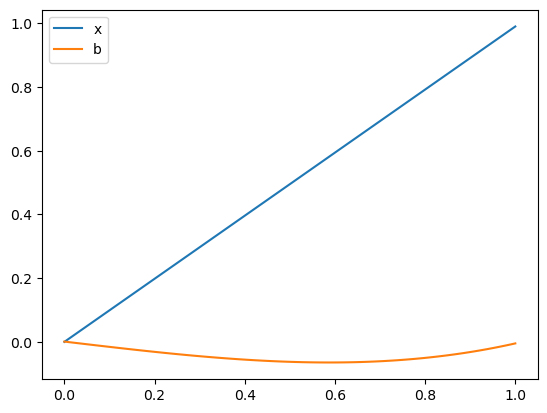

In [5]:

plt.figure()
plt.plot(np.linspace(0,1,n),x, label='x')
plt.plot(np.linspace(0,1,n),b, label='b')
plt.plot()
plt.legend()
plt.show()



This has made a A, x, and b where Ax=b. We can check check this is the case up to floating point error: 

In [6]:
np.linalg.norm(A@x-b)

0.0

Now make a version of b with noise

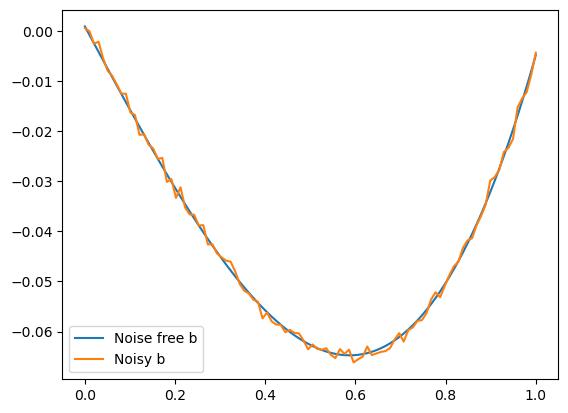

In [7]:
bn= b + 0.001*np.random.randn(n)
plt.figure()
plt.plot(np.linspace(0,1,n),b, label='Noise free b')
plt.plot(np.linspace(0,1,n),bn, label='Noisy b')
plt.legend()
plt.show()


$A$, $x$ and $b$ are stored as Numpy arrays. Just as in Matlab we can look at the singular value decomposition (SVD).   On a log scale we see the singular values decay as a negative power as expected for an operator that approximates the inverse of two derivatives.


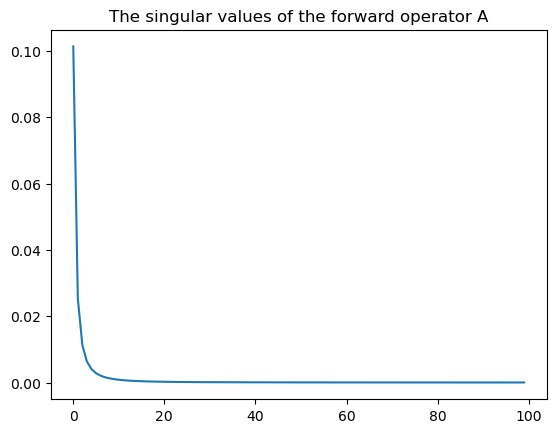

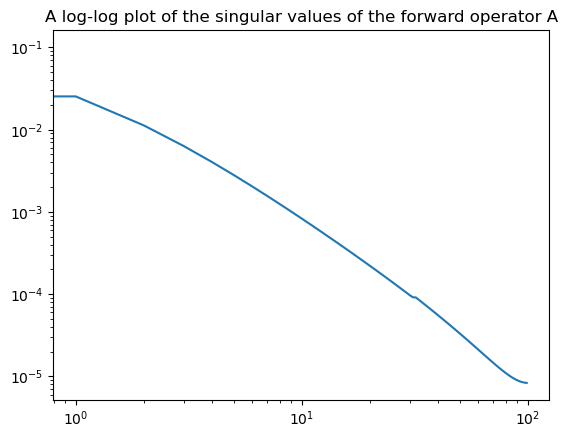

In [8]:
u, s, vh = np.linalg.svd(A, full_matrices=True)
plt.figure()
plt.plot(s)
plt.title('The singular values of the forward operator A')
plt.show()
plt.figure()
plt.loglog(s)
plt.title('A log-log plot of the singular values of the forward operator A')
plt.show()



Solving the least squares problem $\min_x\|Ax-b\|_2^2$ demonstrates the ill-posedness of the problem:

<Figure size 640x480 with 0 Axes>

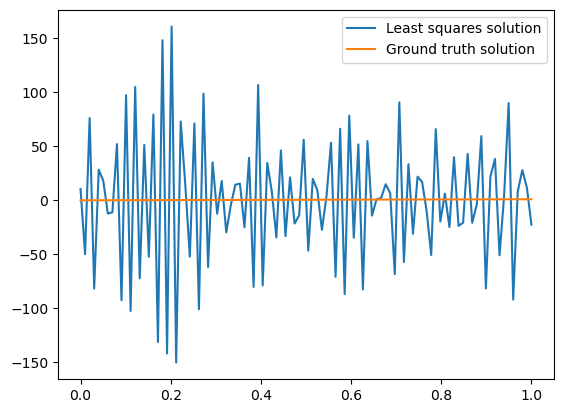

<Figure size 640x480 with 0 Axes>

In [9]:
xlq=np.linalg.lstsq(A,bn,rcond=None)[0]

plt.figure()
plt.plot(np.linspace(0,1,n),xlq, label='Least squares solution')
plt.plot(np.linspace(0,1,n),x, label='Ground truth solution')
plt.legend()
plt.figure()



We see the solution matches the observed data well:

In [10]:
np.linalg.norm(A@xlq-bn)

4.731464782457117e-15

However this is not a desired solution to our inverse problem. Now, instead, solve using Tikonov regularization: 

<Figure size 640x480 with 0 Axes>

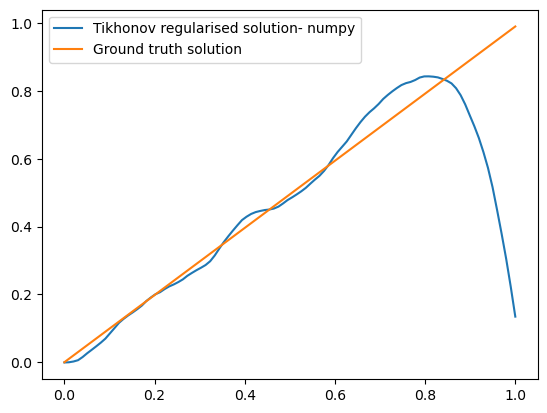

<Figure size 640x480 with 0 Axes>

In [11]:
reg_param= 0.005

Atik=np.vstack((A,reg_param*np.eye(n))) 

btik = np.hstack((bn,np.zeros(n)))

xtik =  np.linalg.lstsq(Atik,btik,rcond=None)[0]
plt.figure()
plt.plot(np.linspace(0,1,n),xtik, label='Tikhonov regularised solution- numpy')
plt.plot(np.linspace(0,1,n),x, label='Ground truth solution')
plt.legend()
plt.figure()


This solution is an improvement, although we still have this odd behaviour at the end of the interval. 

Now convert the matrix and operators to CIL types so we can use inbuilt optimisation routines and regularisers in CIL: 

In [12]:
Aop = MatrixOperator(A)
bop= VectorData(bn) 


We run CGLS to solve the un-regularised least squares problem $$\min_x \|Ax-b\|_2^2.$$ We choose a small number of iterations to implicitly regularise via early stopping: 

100%|██████████| 4/4 [00:00<00:00, 26.95it/s, objective=0.216]


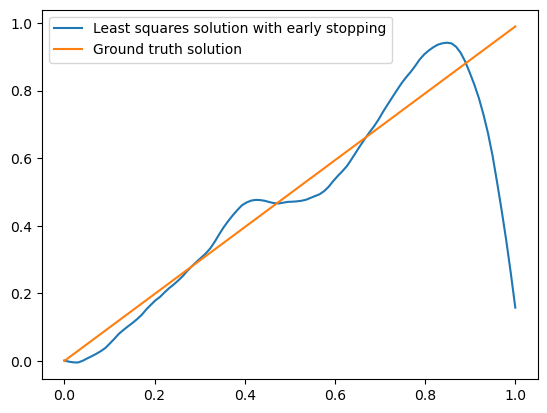

In [13]:
#bop = VectorData(np.reshape(b,[-1]))
op = VectorData(bn)
cgls = CGLS(operator=Aop, data=bop, update_objective_interval=10)
cgls.run(4)

plt.figure()
plt.plot(np.linspace(0,1,100),cgls.solution.as_array(), label='Least squares solution with early stopping')
plt.plot(np.linspace(0,1,100),x, label='Ground truth solution')
plt.legend()
plt.show()

We can also do Tikhonov regularisation using the CIL framework. For example, in the block framework below.
The early stopping callback stops iterations if the change in the objective value between calculations is less than 1e-6

In [14]:
ig = Aop.domain_geometry()
L = IdentityOperator(ig)
operator_block = BlockOperator(Aop, reg_param*L)

zero_data = L.range.allocate(0)
data_block = BlockDataContainer(bop, zero_data)

cglsb = CGLS(operator=operator_block, data=data_block, update_objective_interval=1)
cglsb.run(1000, callbacks=[callbacks.ProgressCallback(), callbacks.EarlyStoppingObjectiveValue()])

  0%|          | 5/1000 [00:00<00:46, 21.52it/s, objective=0.000793]


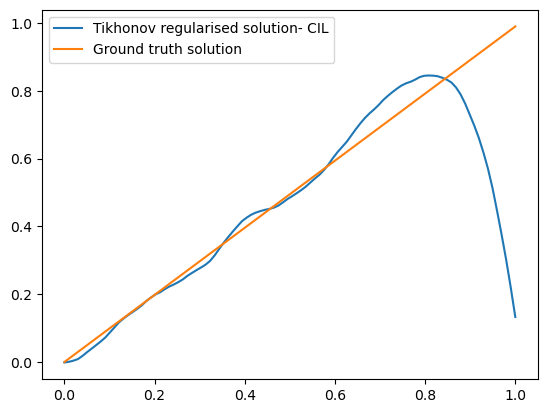

In [15]:
plt.figure()
plt.plot(np.linspace(0,1,n), cglsb.solution.as_array(), label='Tikhonov regularised solution- CIL')
plt.plot(np.linspace(0,1,n),x, label='Ground truth solution')
plt.legend()
plt.show()


We can compare the results of Tikhonov regularisation implemented by numpy and CIL: 

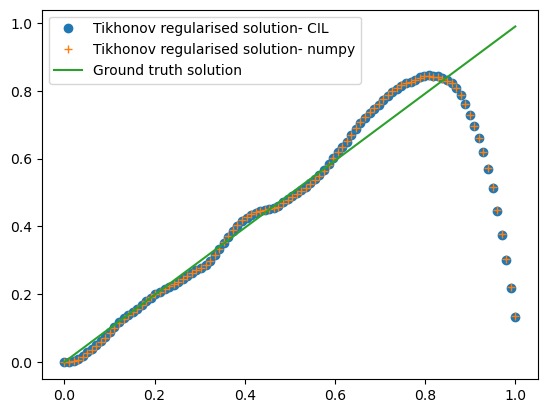

In [16]:
plt.figure()
plt.plot(np.linspace(0,1,n),  cglsb.solution.as_array(),'o', label='Tikhonov regularised solution- CIL')
plt.plot(np.linspace(0,1,n),xtik, '+', label='Tikhonov regularised solution- numpy')
plt.plot(np.linspace(0,1,n),x, label='Ground truth solution')
plt.legend()
plt.show()


You can see that the solutions are identical!

We think the reconstruction error near the boundary at 1 is caused by the discretisation of the integral - for future investigation 